In [1]:
import numpy as np
import matplotlib.pyplot as plt
from util.plot import plot_cdf,plot_lines,plot_box_by_config,plot_box
from util.consts import balance_size_bins, balance_size_bins_label
from util.plot import color_list
import json
import os
from collections import defaultdict

res_size_plot: (2, 66)
res_queue_plot: (2, 257)
error_queue_list: (14658,), mean: 0.1977077363896848, median: 0.0
error_size_list: (2227,), mean: 4.677289015427352, median: 2.85797119140625
size_list: (2227,), max: 73881008.0, min: 1.000046730041504
pkt_list: (14658,), max: 36, min: 0
size_list: max: 73881008.0, min: 1.000046730041504
size_list: max: 36, min: 0


/data1/lichenni/projects/per-flow-sim/util/plot.py:110: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(


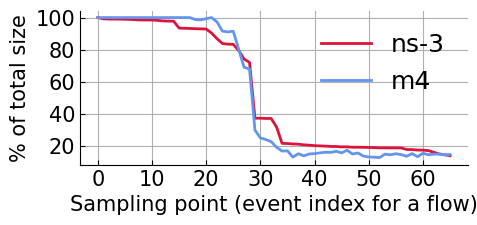

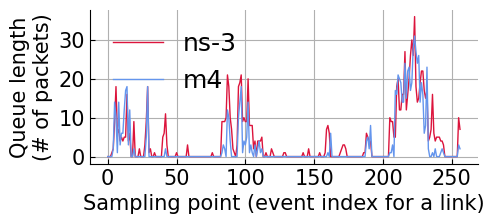

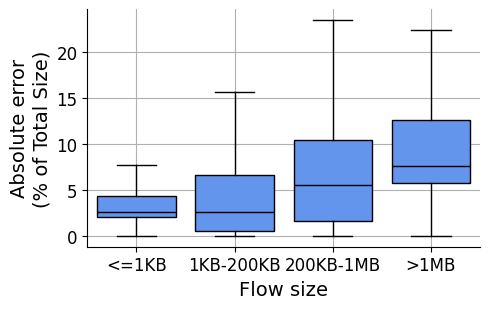

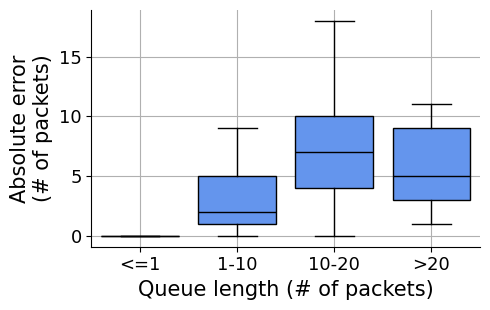

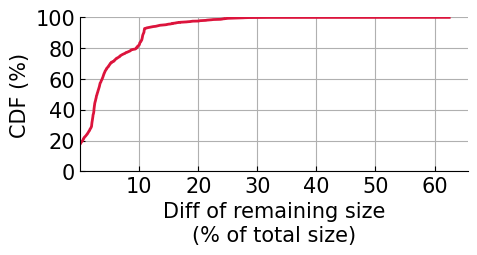

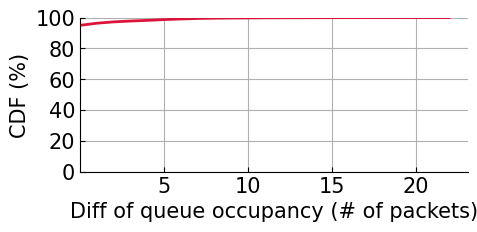

In [8]:
res_dir='/data2/lichenni/output_perflow/new_debug_noflowsim_shard4000_nflows1_nhosts1_nsamples1_lr10Gbps/version_0/test/version_0'

res_size_perflow=[]
res_queue_perlink=[]
error_size_list=[]
size_list=[]
error_queue_list=[]
pkt_list=[]
for scenario_idx in range(100):
    if os.path.exists(f'{res_dir}/{scenario_idx}'):
        
        dir_list=os.listdir(f'{res_dir}/{scenario_idx}')
        for dir_tmp in dir_list:
            res_size_dict=defaultdict(list)
            res_queue_dict=defaultdict(list)
            npz_file=f'{res_dir}/{scenario_idx}/{dir_tmp}/res.npz'
            res=np.load(npz_file)
            res_size=res['res_size'][:2]*100
            res_size[res_size>100]=100
            size_info=(np.exp2(res['size_info'])-1)*1000
            
            res_size_flowidx=res['res_size'][2].astype(int)
            for i in range(res_size.shape[1]):
                res_size_dict[res_size_flowidx[i]].append(res_size[[1,0],i])
            
            for flowidx in res_size_dict:
                tmp=np.array(res_size_dict[flowidx]).T
                error=np.mean(abs(tmp[0]-tmp[1]))
                error_size_list.append(error)
                size_list.append(size_info[flowidx])
            
            res_queue=res['res_queue'][:2]
            res_queue=np.power(res_queue,3).astype(int)
            res_queue_linkidx=res['res_queue'][2]
            for i in range(res_queue.shape[1]):
                res_queue_dict[res_queue_linkidx[i]].append(res_queue[[1,0],i])
            # if np.mean(res_queue[1])>0.5:
            for i in range(res_queue.shape[1]):
                pkt_list.append(res_queue[1,i])
                error_queue_list.append(abs(res_queue[0,i]-res_queue[1,i]))
            res_size_perflow.extend(list(res_size_dict.values()))
            res_queue_perlink.extend(list(res_queue_dict.values()))
            
len_queue=[len(x) for x in res_size_perflow]
sorted_idx=np.argsort(len_queue)
max_idx=sorted_idx[-15]
res_size_plot=np.array(res_size_perflow[max_idx]).T
# res_size_plot[0]=np.sort(res_size_plot[0])[::-1]

len_queue=[len(x) for x in res_queue_perlink]
sorted_idx=np.argsort(len_queue)
max_idx=sorted_idx[-1]
res_queue_plot=np.array(res_queue_perlink[max_idx]).T\

print(f"res_size_plot: {res_size_plot.shape}")
print(f"res_queue_plot: {res_queue_plot.shape}")

error_queue_list=np.array(error_queue_list)
error_size_list=np.array(error_size_list)

print(f"error_queue_list: {error_queue_list.shape}, mean: {np.mean(error_queue_list)}, median: {np.median(error_queue_list)}")
print(f"error_size_list: {error_size_list.shape}, mean: {np.mean(error_size_list)}, median: {np.median(error_size_list)}")

size_list=np.array(size_list)
pkt_list=np.array(pkt_list)
print(f"size_list: {size_list.shape}, max: {np.max(size_list)}, min: {np.min(size_list)}")
print(f"pkt_list: {pkt_list.shape}, max: {np.max(pkt_list)}, min: {np.min(pkt_list)}")

fig_idx=0
data_x=np.arange(0,res_size_plot.shape[1])
plot_data=[(data_x,res_size_plot[0,data_x]),(data_x,res_size_plot[1,data_x])]
plot_lines(
    plot_data,
    f'./figs/eva_size_example.pdf',
    ['ns-3','m4'],
    x_label="Sampling point (event index for a flow)",
    y_label="% of total size",
    title=None,
    # log_switch=True,
    # ylim=139,
    format_idx=[0,2],
    legend_cols=1,
    legend_font=18,
    fig_idx=fig_idx,
    linewidth=2,
    loc=1
)
fig_idx+=1

data_x=np.arange(0, res_queue_plot.shape[1])
plot_data=[(data_x,res_queue_plot[0,data_x]),(data_x,res_queue_plot[1,data_x])]
plot_lines(
    plot_data,
    f'./figs/eva_queue_example.pdf',
    ['ns-3','m4'],
    x_label="Sampling point (event index for a link)",
    y_label="Queue length\n(# of packets)",
    title=None,
    # log_switch=True,
    # ylim=24,
    format_idx=[0,2],
    legend_cols=1,
    legend_font=18,
    fig_idx=fig_idx,
    linewidth=1,
    # loc=9
)

fig_idx+=1

size_buckets = [0, 1 * 1024, 200 * 1024, 1024 * 1024, np.inf]  # Sizes in bytes
bucket_labels = ['<=1KB', '1KB-200KB','200KB-1MB', '>1MB']
# Sort data
sorted_indx = np.argsort(size_list)
data_x = np.array(size_list)[sorted_indx]
error_y = np.array(error_size_list)[sorted_indx]
print(f"size_list: max: {np.max(data_x)}, min: {np.min(data_x)}")
# Group data into buckets
bucketed_data = {label: [] for label in bucket_labels}
for size, error in zip(data_x, error_y):
    for i in range(len(size_buckets) - 1):
        if size_buckets[i] <= size < size_buckets[i+1]:
            bucketed_data[bucket_labels[i]].append(error)
            break
plot_box(
    bucketed_data,
    bucket_labels,
    [],
    n_methods=1,
    x_label='Flow size',
    y_label="Absolute error\n(% of Total Size)",
    title=None,
    fontsize=14,
    legend_font=15,
    loc=3,
    rotate_xaxis=False,
    file_name=f'./figs/eva_size_error.pdf',
    remove_outliers=True,
    fig_idx=fig_idx,
)
fig_idx+=1


pkt_buckets = [0, 1, 10, 20, np.inf]  # Sizes in bytes
bucket_labels = ['<=1','1-10' ,'10-20', '>20']
# Sort data
sorted_indx = np.argsort(pkt_list)
data_x = np.array(pkt_list)[sorted_indx]
error_y = np.array(error_queue_list)[sorted_indx]
print(f"size_list: max: {np.max(data_x)}, min: {np.min(data_x)}")
# Group data into buckets
bucketed_data = {label: [] for label in bucket_labels}
for size, error in zip(data_x, error_y):
    for i in range(len(pkt_buckets) - 1):
        if pkt_buckets[i] <= size < pkt_buckets[i+1]:
            bucketed_data[bucket_labels[i]].append(error)
            break
plot_box(
    bucketed_data,
    bucket_labels,
    [],
    n_methods=1,
    x_label='Queue length (# of packets)',
    y_label="Absolute error\n(# of packets)",
    title=None,
    fontsize=15,
    legend_font=15,
    loc=3,
    rotate_xaxis=False,
    file_name=f'./figs/eva_queue_error.pdf',
    remove_outliers=True,
    fig_idx=fig_idx,
)
fig_idx+=1

plot_cdf(
    [error_size_list],
    # f'./figs/eva_large_scale_cdf.pdf',
    None,
    [],
    x_label="Diff of remaining size\n(% of total size)",
    log_switch=False,
    rotate_xaxis=False,
    # xlim=100,
    xlim_bottom=0.01,
    fontsize=15,
    legend_font=18,
    loc=4,
    enable_abs=True,
    group_size=5,
    fig_idx=fig_idx
)
fig_idx+=1
            
plot_cdf(
    [error_queue_list],
    # f'./figs/eva_large_scale_cdf.pdf',
    None,
    [],
    x_label="Diff of queue occupancy (# of packets)",
    log_switch=False,
    rotate_xaxis=False,
    # xlim=100,
    xlim_bottom=0.01,
    fontsize=15,
    legend_font=18,
    loc=4,
    enable_abs=True,
    group_size=5,
    fig_idx=fig_idx
)

In [73]:
# Define constants
n_scenario = 100
empirical_str = "eval_test"
legend_list = ["flowSim", "m4"]
model_instance_list = ["flowsim", "new_loss01_mlp1_10"]

n_methods = len(legend_list)

# Load configurations
config_file = f"/data1/lichenni/projects/per-flow-sim/parsimon-eval/expts/fig_8/spec/eval_test.mix.json"
configs = json.load(open(config_file))

# Find available scenarios
index_list_ori = []
for i in range(n_scenario):
    if os.path.exists(
        f"/data1/lichenni/projects/per-flow-sim/parsimon-eval/expts/fig_8/{empirical_str}/{i}/ns3/flowsim_fct.npy"
    ):
        index_list_ori.append(i)

# Prepare config_list
index_list = []
config_list = []
for idx, i in enumerate(index_list_ori):
    config = configs[i]
    max_load = float(config["max_load"])
    cc = config["cc"]  # Congestion control algorithm
    config_list.append([max_load, cc])  # Include max_load and cc
    index_list.append(idx)
config_list = np.array(config_list)

# Define flow size buckets and labels
size_bins = [0, 1 * 1000, 10 * 1000, 50 * 1000, np.inf]  # Sizes in bytes
size_bin_labels = ["<=1KB", "1KB-10KB", "10KB-50KB", ">50KB"]

# Define max load groups
max_load_bins = [0, 0.50, np.inf]
max_load_labels = ["<50%", ">50%"]

# Initialize error storage
error_by_model = {
    model: {
        cc: {load: {label: [] for label in size_bin_labels} for load in max_load_labels}
        for cc in set(config_list[:, 1])
    }
    for model in legend_list
}

# Process scenarios
for idx, scenario_idx in enumerate(index_list):
    # Load flow sizes
    fid=np.load(f'/data1/lichenni/projects/per-flow-sim/parsimon-eval/expts/fig_8/{empirical_str}/{scenario_idx}/ns3/fid_topology_flows.npy')
    sizes = np.load(
        f"/data1/lichenni/projects/per-flow-sim/parsimon-eval/expts/fig_8/{empirical_str}/{scenario_idx}/ns3/fsize.npy"
    )[fid]

    # Flatten sizes to match dimensions with relative errors
    sizes = sizes.flatten()

    # Group flows into size buckets
    size_indices = np.digitize(sizes, size_bins)

    # Get max load and CC group for the scenario
    max_load = config_list[idx, 0]
    cc = config_list[idx, 1]
    load_group = max_load_labels[np.digitize(max_load, max_load_bins, right=False) - 1]

    # Process each model instance
    for model_idx, model_instance in enumerate(model_instance_list):
        model_name = legend_list[model_idx]
        data = np.load(f"./res/{model_instance}{empirical_str}.npz")
        sldn = data["fct"]
        predicted_sldns = sldn[scenario_idx, : len(sizes), 0]
        actual_sldns = sldn[scenario_idx, : len(sizes), 1]

        # Calculate relative errors
        relative_errors = np.abs(actual_sldns - predicted_sldns) / actual_sldns * 100

        # Flatten relative_errors to match sizes
        relative_errors = relative_errors.flatten()

        # Group errors into buckets
        for b in range(1, len(size_bins)):
            bin_mask = size_indices == b
            bin_errors = relative_errors[bin_mask]
            error_by_model[model_name][cc][load_group][size_bin_labels[b - 1]].extend(
                bin_errors
            )

# Calculate mean error for each model, CC, max load group, and size bucket
mean_error_results = {
    model: {
        cc: {
            load: {
                bucket: np.mean(errors) if errors else 0
                for bucket, errors in group.items()
            }
            for load, group in load_group_dict.items()
        }
        for cc, load_group_dict in cc_group_dict.items()
    }
    for model, cc_group_dict in error_by_model.items()
}

num_results = {
    model: {
        cc: {
            load: {bucket: len(errors) for bucket, errors in group.items()}
            for load, group in load_group_dict.items()
        }
        for cc, load_group_dict in cc_group_dict.items()
    }
    for model, cc_group_dict in error_by_model.items()
}

# Print results
print("Mean Error by Model, CC, Load Group, and Flow Size Bucket:")
for model, cc_group_dict in mean_error_results.items():
    print(f"\nModel: {model}")
    for cc, load_group_dict in cc_group_dict.items():
        print(f"  Congestion Control: {cc}")
        for load, group in load_group_dict.items():
            print(f"    Load Group: {load}")
            for bucket, mean_error in group.items():
                print(f"      {bucket}: {mean_error:.2f}%")

print("Num of Results by Model, CC, Load Group, and Flow Size Bucket:")
for model, cc_group_dict in num_results.items():
    print(f"\nModel: {model}")
    for cc, load_group_dict in cc_group_dict.items():
        print(f"  Congestion Control: {cc}")
        for load, group in load_group_dict.items():
            print(f"    Load Group: {load}")
            for bucket, num in group.items():
                print(f"      {bucket}: {num}")


Mean Error by Model, CC, Load Group, and Flow Size Bucket:

Model: flowSim
  Congestion Control: dctcp
    Load Group: <50%
      <=1KB: 5.49%
      1KB-10KB: 5.79%
      10KB-50KB: 20.24%
      >50KB: 28.12%
    Load Group: >50%
      <=1KB: 8.50%
      1KB-10KB: 7.94%
      10KB-50KB: 25.59%
      >50KB: 30.88%
  Congestion Control: timely
    Load Group: <50%
      <=1KB: 6.17%
      1KB-10KB: 6.84%
      10KB-50KB: 24.19%
      >50KB: 27.63%
    Load Group: >50%
      <=1KB: 6.26%
      1KB-10KB: 6.59%
      10KB-50KB: 21.07%
      >50KB: 25.99%
  Congestion Control: dcqcn
    Load Group: <50%
      <=1KB: 3.14%
      1KB-10KB: 5.69%
      10KB-50KB: 28.65%
      >50KB: 40.08%
    Load Group: >50%
      <=1KB: 5.93%
      1KB-10KB: 7.25%
      10KB-50KB: 26.26%
      >50KB: 34.16%

Model: m4
  Congestion Control: dctcp
    Load Group: <50%
      <=1KB: 5.43%
      1KB-10KB: 5.93%
      10KB-50KB: 9.94%
      >50KB: 8.34%
    Load Group: >50%
      <=1KB: 8.44%
      1KB-10KB: 8.42%

flowsim-sldn: (3, 20000)
new_loss01_mlp1_10-sldn: (3, 20000)
new_debug_noflowsim_10-sldn: (3, 20000)
new_debug_10-sldn: (3, 20000)
mean error:[8.162544198843557, 6.715788581765101, 7.497966148823411, 7.168771847366384]
median error:[8.278238710600169, 6.012114276745362, 6.746516250703756, 7.964161353899914]
p99 error:[20.838991904211976, 14.184392934873761, 15.120212325018946, 11.670918302357023]


TypeError: list indices must be integers or slices, not tuple

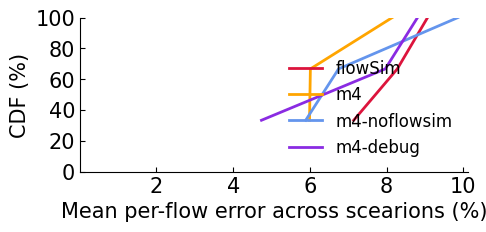

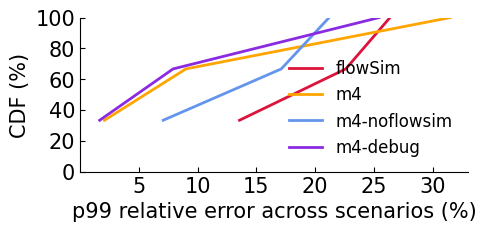

In [12]:
n_scenario=3
empirical_str = "eval_test"
# legend_list=['flowSim','m4','m4-12','m4-11']
# model_instance_list=['flowsim','final_10','final_noflowsim_12','final_noflowsim_11']
# legend_list=['flowSim','m4-12','m4-11','m4-10','m4-9','m4-8']
# model_instance_list=['flowsim','new_loss01_mlp1_nosize_12','new_loss01_mlp1_nosize_11','new_loss01_mlp1_nosize_10','new_loss01_mlp1_nosize_9','new_loss01_mlp1_nosize_8',]
# legend_list=['flowSim','m4-12','m4-11','m4-10','m4-9','m4-8','m4-7','m4-6','m4-5']
# model_instance_list=['flowsim','new_loss01_mlp1_noqueue_12','new_loss01_mlp1_noqueue_11','new_loss01_mlp1_noqueue_10','new_loss01_mlp1_noqueue_9','new_loss01_mlp1_noqueue_8','new_loss01_mlp1_noqueue_7','new_loss01_mlp1_noqueue_6','new_loss01_mlp1_noqueue_5']
# legend_list=['flowSim','m4-16','m4-15','m4-14','m4-13','m4-12','m4-11','m4-10','m4-9','m4-8','m4-7','m4-6']
# model_instance_list=['flowsim','new_loss01_mlp1_16','new_loss01_mlp1_15','new_loss01_mlp1_14','new_loss01_mlp1_13','new_loss01_mlp1_12','new_loss01_mlp1_11','new_loss01_mlp1_10','new_loss01_mlp1_9','new_loss01_mlp1_8','new_loss01_mlp1_7','new_loss01_mlp1_6']
# legend_list=['flowSim','m4-12','m4-11','m4-10','m4-9','m4-8','m4-7','m4-6','m4-5']
# model_instance_list=['flowsim','new_loss01_mlp1_noflowsim_12','new_loss01_mlp1_noflowsim_11','new_loss01_mlp1_noflowsim_10','new_loss01_mlp1_noflowsim_9','new_loss01_mlp1_noflowsim_8','new_loss01_mlp1_noflowsim_7','new_loss01_mlp1_noflowsim_6','new_loss01_mlp1_noflowsim_5']
# legend_list=['flowSim','m4-12','m4-11','m4-10','m4-9','m4-8','m4-7','m4-6','m4-5']

# model_instance_list=['flowsim','new_loss01_mlp1_10','new_debug_12','new_debug_11','new_debug_10','new_debug_9','new_debug_8','new_debug_7','new_debug_6','new_debug_5']
# legend_list=['flowSim','m4','m4-12','m4-11','m4-10','m4-9','m4-8','m4-7','m4-6','m4-5']

# model_instance_list=['flowsim','new_loss01_mlp1_10','new_debug_noflowsim_12','new_debug_noflowsim_11','new_debug_noflowsim_10','new_debug_noflowsim_9','new_debug_noflowsim_8','new_debug_noflowsim_7','new_debug_noflowsim_6','new_debug_noflowsim_5']
# legend_list=['flowSim','m4','m4-12','m4-11','m4-10','m4-9','m4-8','m4-7','m4-6','m4-5']

legend_list=['flowSim','m4','m4-noflowsim','m4-debug']
model_instance_list=['flowsim','new_loss01_mlp1_10','new_debug_noflowsim_10','new_debug_10']
                     
n_methods = len(legend_list)
config_file=f'/data1/lichenni/projects/per-flow-sim/parsimon-eval/expts/fig_8/spec/eval_test.mix.json'
configs=json.load(open(config_file))

index_list_ori=[]
for i in range(n_scenario):
    if os.path.exists(f'/data1/lichenni/projects/per-flow-sim/parsimon-eval/expts/fig_8/{empirical_str}/{i}/ns3/flowsim_fct.npy'):
        index_list_ori.append(i)
index_list=[]
config_list=[]
for idx,i in enumerate(index_list_ori):
    config=configs[i]
    spatial=config['spatial'].split('/')[-1].split('.')[0]
    size_dist=config['size_dist'].split('/')[-1].split('.')[0]
    cluster=config['cluster'].split('/')[-1].split('.')[0]
    max_load=float(config['max_load'])
    lognorm_sigma=float(config['lognorm_sigma'])
    cc=config['cc']
    bfsz=float(config['bfsz'])
    fwin=float(config['window'])
    
    config_list.append([spatial, size_dist, cluster, max_load, lognorm_sigma,cc,bfsz,fwin])
    index_list.append(idx)
config_list=np.array(config_list)

error_list=[]
error_list_p99=[]
for model_instance in model_instance_list:
    data_m4 = np.load(f'./res/{model_instance}{empirical_str}.npz')
    sldn = data_m4['fct']
    predicted_sldns = sldn[index_list, :, 0]
    actual_sldns = sldn[index_list,:, 1]
    print(f"{model_instance}-sldn: {predicted_sldns.shape}")
    
    predicted_sldns[predicted_sldns==0]=1
    actual_sldns[actual_sldns==0]=1
    # calculate the relative error
    relative_error_sldn = np.mean(np.abs(actual_sldns - predicted_sldns) / actual_sldns *100, axis=1)
    # relative_error_sldn = np.abs(actual_sldns - predicted_sldns) / actual_sldns *100
    sldn_p99_est=np.percentile(predicted_sldns,99,axis=1)
    sldn_p99_act=np.percentile(actual_sldns,99,axis=1)
    
    error_list.append(relative_error_sldn)
    error_list_p99.append(np.abs(sldn_p99_est-sldn_p99_act)/sldn_p99_act*100)
config_list=config_list[index_list]
error_list=np.array(error_list)
error_list_p99=np.array(error_list_p99)

# print(f"p99 error:{[np.percentile(x,99) for x in error_list]}")
print(f"mean error:{[np.mean(x) for x in error_list]}")
print(f"median error:{[np.median(x) for x in error_list]}")
print(f"p99 error:{[np.mean(x) for x in error_list_p99]}")

plot_cdf(
    error_list,
    None,
    legend_list,
    x_label="Mean per-flow error across scearions (%)",
    log_switch=False,
    rotate_xaxis=False,
    # ylim_low=90,
    # xlim=150,
    xlim_bottom=0.01,
    fontsize=15,
    legend_font=12,
    loc=4,
    enable_abs=True,
    group_size=5,
    fig_idx=0,
)

plot_cdf(
    error_list_p99,
    None,
    legend_list,
    x_label="p99 relative error across scenarios (%)",
    log_switch=False,
    rotate_xaxis=False,
    # ylim_low=90,
    # xlim=150,
    xlim_bottom=0.01,
    fontsize=15,
    legend_font=12,
    loc=4,
    enable_abs=True,
    group_size=5,
    fig_idx=1,
)

# Discretize the max_load values
max_load_values = np.array([config[3] for config in config_list], dtype=float)
bins = [0.3, 0.4,0.5, 0.6, 0.7, 0.8]
labels = ['0.3-0.4', '0.4-0.5', '0.5-0.6', '0.6-0.7', '0.7-0.8']
max_load_bins = np.digitize(max_load_values, bins, right=False) - 1
max_load_labels = [labels[i] for i in max_load_bins]
for idx, config in enumerate(config_list):
    config[3] = max_load_labels[idx]
    
bfsz_values = np.array([config[6] for config in config_list], dtype=float)
bins = [10,12,14,16,18,20]
labels = ['10-12', '12-14', '14-16', '16-18', '18-20']
bfsz_bins = np.digitize(bfsz_values, bins, right=False) - 1
bfz_labels = [labels[i] for i in bfsz_bins]
for idx, config in enumerate(config_list):
    config[6] = bfz_labels[idx]

fwin_values=np.array([config[7] for config in config_list], dtype=float)
bins = [10000,12000,14000,16000,18000,20000]
labels = ['10000-12000', '12000-14000', '14000-16000', '16000-18000', '18000-20000']
fwin_bins = np.digitize(fwin_values, bins, right=False) - 1
fwin_labels = [labels[i] for i in fwin_bins]
for idx, config in enumerate(config_list):
    config[7] = fwin_labels[idx]
# Convert config_list to a NumPy array for easier indexing
config_list = np.array(config_list)


# Function to plot box plots for each configuration type
# def plot_box_by_config(error_list, config_list, legend_list, config_index, config_name):
#     unique_configs = np.unique(config_list[:, config_index])
#     n_methods = len(legend_list)
    
#     # Prepare data for each unique configuration type
#     data_to_plot = {config_value: [[] for _ in range(n_methods)] for config_value in unique_configs}
#     for i, config_value in enumerate(config_list[:, config_index]):
#         for j in range(n_methods):
#             data_to_plot[config_value][j].append(error_list[i, j])
    
#     # Plot the data
#     plt.figure(figsize=(10, 6))
#     x_positions = np.arange(len(unique_configs))
#     box_width = 0.8 / n_methods  # Adjust width based on number of methods
#     colors = ['lightblue', 'lightcoral', 'lightgreen', 'lightyellow']
#     handles = []
    
#     for j, method_label in enumerate(legend_list):
#         method_data = [data_to_plot[config_value][j] for config_value in unique_configs]
#         positions = x_positions - 0.4 + (j + 0.5) * box_width  # Center the boxes
#         bp = plt.boxplot(method_data, positions=positions, widths=box_width,
#                          patch_artist=True, 
#                          boxprops=dict(facecolor=colors[j % len(colors)], color=colors[j % len(colors)]),
#                          medianprops=dict(color="black"))
#         handles.append(bp["boxes"][0])

#     plt.title(f"Relative Error by {config_name} Configuration")
#     plt.xlabel(config_name)
#     plt.ylabel("Relative Error (%)")
#     plt.xticks(x_positions, unique_configs, rotation=45)
#     plt.legend(handles, legend_list)
#     plt.grid(True)
#     plt.tight_layout()
#     plt.show()

# Generate plots for each configuration attribute
config_attributes = ["Spatial", "Size Distribution", "Cluster", "Max Load", "Lognorm Sigma", "CC", "BFSZ", "FWIN"]
for i, config_name in enumerate(config_attributes):
    plot_box_by_config(error_list.T, config_list, legend_list, config_index=i, config_name=config_name)

ns-3: 94
m4: 94
ns-3: 2907.9704255319148, m4: 241.19317416941865, flowsim: 56.40186381340027


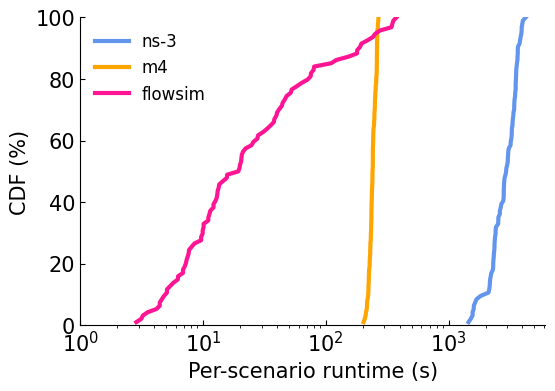

In [ ]:
import re
n_scenario=100
empirical_str='eval_test_8k'
data_root="/data1/lichenni/projects/per-flow-sim/parsimon-eval/expts/fig_8"
legend_list=['ns-3', 'm4', 'flowsim']
res=[]

time_ns3=[]
'''
for i in range(n_scenario):
    if os.path.exists(f'{data_root}/{empirical_str}/{i}/ns3/flowsim_fct.npy'):
        time_file=f'{data_root}/{empirical_str}/{i}/ns3/elapsed.txt'
        with open(time_file, "r") as file:
            number = float(file.read().strip())
            time_ns3.append(number)
res.append(time_ns3)     
print(f"ns-3: {len(time_ns3)}")  
'''

with open(f'{data_root}/{empirical_str}/ns3_times.txt') as f:
    time_ns3 = [float(txt.replace("\n", "")) for txt in f.readlines()]

print(f"ns-3: {len(time_ns3)}")  
res.append(time_ns3)

def read_log_file(file_path):
    try:
        with open(file_path, 'r') as file:
            log_text = file.read()
        return log_text
    except FileNotFoundError:
        print(f"Error: The file {file_path} was not found.")
        return None

def extract_scenario_times(log_text):
    # Regex patterns for time elapsed and workload scenario
    time_pattern = r"Time elapsed:\s([\d.]+)"

    # Extract times and workload IDs
    elapsed_times = re.findall(time_pattern, log_text)

    # Create a dictionary mapping scenario ID to time elapsed
    scenario_times = []
    for workload_idx, time in enumerate(elapsed_times):
        time=float(time)
        scenario_times.append(float(time))
    
    return scenario_times

log_text = read_log_file(f'{empirical_str}.log')
time_m4 = extract_scenario_times(log_text)
res.append(time_m4)
print(f"m4: {len(time_m4)}")

with open(f'{data_root}/{empirical_str}/flowsim_times.txt') as f:
    flowsim_times = [float(txt.replace("\n", "")) for txt in f.readlines()]

res.append(flowsim_times)

res=np.array(res)
print(f"ns-3: {np.mean(res[0])}, m4: {np.mean(res[1])}, flowsim: {np.mean(res[2])}")

fig_index=0
plot_cdf(
    res,
    None,
    legend_list,
    x_label="Per-scenario runtime (s)",
    log_switch=True,
    rotate_xaxis=False,
    # ylim_low=90,
    # xlim=150,
    xlim_bottom=1,
    fontsize=15,
    legend_font=12,
    loc=2,
    enable_abs=True,
    group_size=5,
    fig_idx=fig_index
)
fig_index=1